In [28]:
import os, sys, pandas as pd, pickle, torch, torch.nn as nn, copy
sys.path.append("/content")
from src.utils import plot_obs_predict, fit_mlp_full, MultipleRegression
os.chdir("/content")
with open("/content/credentials") as f:
    env_vars = f.read().split("\n")

for var in env_vars:
    key, value = var.split(" = ")
    os.environ[key] = value

storage_options = {"account_name":os.environ["ACCOUNT_NAME"],
                   "account_key":os.environ["BLOB_KEY"]}


In [29]:
results = pd.read_csv("output/mlp/grid_search_metadata.csv")
no_azimuth = ["mean_viewing_azimuth" not in results["features"][i] for i in range(0, (results.shape[0]))]
results_sub = copy.copy(results.loc[no_azimuth, :])

results_to_use = results_sub
results_to_use["mean_mse"] = (results_to_use["val_site_mse"] + results_to_use["val_pooled_mse"]) / 2

with open(results_to_use.iloc[results_to_use["mean_mse"].argmin(), :]["path"], "rb") as f:
    top_model = pickle.load(f)

# from sklearn.metrics import r2_score
# part = "validation"
# my_fold = 1

# if part == "validation":
#     pred_fold = top_model["y_pred_val_fold"]
#     y_fold = top_model["y_obs_val_fold"]
# else:
#     pred_fold = top_model["y_pred_train_fold"]
#     y_fold = top_model["y_obs_train_fold"]

# print(f"R2: {r2_score(pred_fold[my_fold], y_fold[my_fold])}")
# plot_obs_predict(pd.DataFrame({"pred": pred_fold[my_fold], "obs": y_fold[my_fold]}), f"Observed vs. Predicted, Fold {my_fold+1}")

In [30]:
## Fit the full model based on top model above
from torch import nn
model_out = fit_mlp_full(
    features=top_model["features"],
    learning_rate=top_model["learning_rate"],
    batch_size=top_model["batch_size"],
    epochs=top_model["epochs"],
    storage_options=storage_options,
    activation_function=eval(f'nn.{top_model["activation"]}'),
    day_tolerance=top_model["day_tolerance"],
    cloud_thr=top_model["cloud_thr"],
    mask_method1="lulc",
    mask_method2="mndwi",
    min_water_pixels=20,
    layer_out_neurons=top_model["layer_out_neurons"],
    learn_sched_step_size=top_model["learn_sched_step_size"],
    learn_sched_gamma=top_model["learn_sched_gamma"],
    verbose=True,
    model_out="/content/output/mlp/top_model"
)

R2: 0.6900067440786848


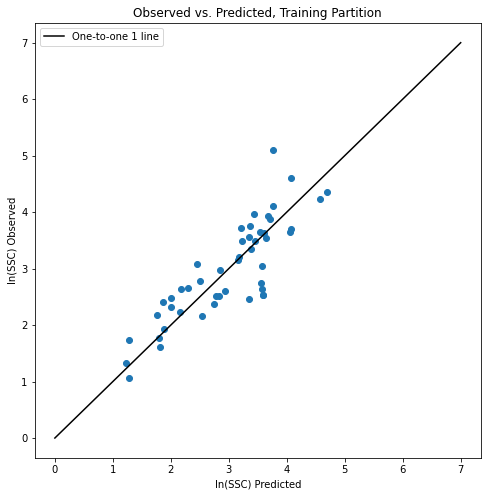

In [44]:
from sklearn.metrics import r2_score

pred = pd.DataFrame(
    {
        "obs": model_out["y_obs_test"],
        "pred": model_out["y_pred_test"],
        "sample_id": model_out["y_test_sample_id"]
    }
)

# pred_good = pred.loc[(pred["obs"] < 5.25) & (pred["obs"] > 0.5), :]
pred_itv = pred.loc[["ITV" in x for x in pred["sample_id"]], :]
pred_data = pred_itv
print(f'R2: {r2_score([x+0.45 for x in pred_data["pred"]], pred_data["obs"])}')

plot_obs_predict(pd.DataFrame({"pred": [x+0.45 for x in pred_data["pred"]], "obs":  pred_data["obs"]}), f"Observed vs. Predicted, Training Partition")

In [45]:
import fsspec
fs = fsspec.filesystem("az", **storage_options)

In [47]:
fs.put_file("/content/output/mlp/top_model.pt", "model-output/mlp/top_model.pt", overwrite=True)
fs.put_file("/content/output/mlp/grid_search_metadata.csv", "model-output/mlp/grid_search_metadata.csv", overwrite=True)
fs.put_file("/content/output/mlp/top_model_metadata.pickle", "model-output/mlp/top_model_metadata.pickle", overwrite=True)

In [52]:
paths_full = os.listdir("/content/output/mlp/500m_cloudthr80_lulcmndwi_masking_tmp_5fold")
paths = [os.path.basename(x) for x in paths_full]

for path in paths:
    fs.put_file(
        f"output/mlp/500m_cloudthr80_lulcmndwi_masking_tmp_5fold/{path}",
        f"model-output/mlp/500m_cloudthr80_lulcmndwi_masking_tmp_5fold/{path}"
    )

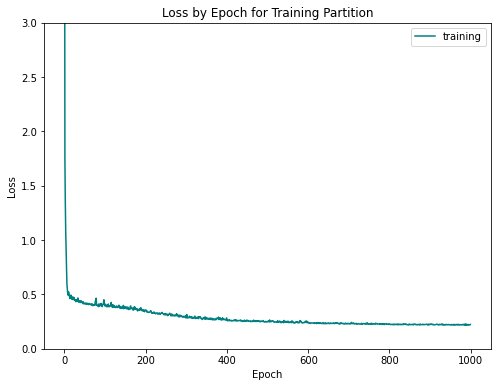

In [49]:
from matplotlib import pyplot as plt

lost_list = model_out["train_loss"]

plt.figure(figsize=(8,6))
plt.plot(lost_list, color="teal", label="training")
plt.title(f"Loss by Epoch for Training Partition")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim((0, 3))
plt.legend()
plt.show()